In [1]:
!pip install scikit-optimize
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from joblib import Parallel, delayed
from skopt import gp_minimize

# Load and reproject geospatial data
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
gdf = gpd.read_file(url).to_crs(epsg=3857)

# Feature engineering
gdf['x'] = gdf.centroid.x
gdf['y'] = gdf.centroid.y
gdf['area'] = gdf.area
gdf['perimeter'] = gdf.length
gdf['label'] = (gdf['POP_EST'] > 1e7).astype(int)

# Data preprocessing
features = gdf[['x', 'y', 'area', 'perimeter']].values
labels = gdf['label'].values
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Data split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Build Dataset
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Teacher Model
# Teacher Model
def build_teacher_model():
    model = models.Sequential([
        layers.Input(shape=(4,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Calculate the split index for validation data
    split_index = int(x_train.shape[0] * (1 - 0.1))  # 0.1 for 10% validation split

    # Split the training data into training and validation sets manually
    x_train_split, x_val_split = x_train[:split_index], x_train[split_index:]
    y_train_split, y_val_split = y_train[:split_index], y_train[split_index:]

    # Fit the model using the split data
    model.fit(x_train_split, y_train_split, epochs=15, verbose=0, validation_data=(x_val_split, y_val_split), callbacks=[lr_scheduler])
    return model

teacher_model = build_teacher_model()
temperature = 3.0
logits = teacher_model.predict(x_train)
soft_labels = tf.nn.sigmoid(logits / temperature).numpy()

# Student Model Objective Function
def objective_function(params):
    learning_rate, batch_size, alpha = params
    batch_size = max(16, int(batch_size))

    student_model = models.Sequential([
        layers.Input(shape=(4,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    student_model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    student_model.fit(x_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.1, verbose=0, callbacks=[early_stopping])

    _, accuracy = student_model.evaluate(x_test, y_test, verbose=0)
    return -accuracy

# Bayesian Optimization
search_space = [(1e-4, 1e-2), (16, 128), (0.1, 0.9)]

result = gp_minimize(objective_function, search_space, n_calls=20, random_state=42)

best_params = result.x
best_accuracy = -result.fun

print(f'Best Parameters: {best_params}, Best Accuracy: {best_accuracy}')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.3 MB/s eta 0:00:00
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Best Parameters: [0.0060088165636702235, np.int64(66), 0.17997993265440235], Best Accuracy: 0.5277777910232544


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


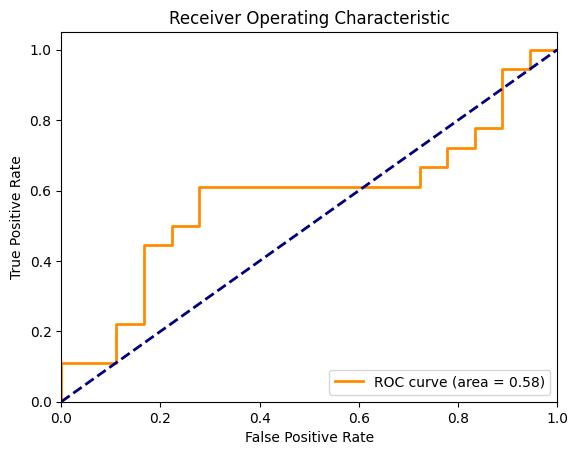

AUC: 0.5771604938271605


In [2]:
# prompt: please draw the ROC curve and calculate the AUC

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'student_model' is the best student model from the Bayesian Optimization
# Rebuild the student model with the best hyperparameters
learning_rate, batch_size, alpha = best_params
batch_size = max(16, int(batch_size))

student_model = models.Sequential([
    layers.Input(shape=(4,)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
student_model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
student_model.fit(x_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.1, verbose=0, callbacks=[early_stopping])


# Predict probabilities for the test set
y_pred_prob = tf.nn.sigmoid(student_model.predict(x_test)).numpy()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc}")


In [3]:
# Enhanced Knowledge Distillation with Multiple Threshold Analysis
# Complete Implementation with Class Balance Robustness Checks

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, confusion_matrix)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

class MultipleThresholdAnalyzer:
    def __init__(self, thresholds=[0.3, 0.5, 0.7, 0.9]):
        self.thresholds = thresholds

    def evaluate_thresholds(self, y_true, y_prob):
        results = []
        for threshold in self.thresholds:
            y_pred = (y_prob >= threshold).astype(int)

            metrics = {
                'threshold': threshold,
                'accuracy': accuracy_score(y_true, y_pred),
                'precision': precision_score(y_true, y_pred, zero_division=0),
                'recall': recall_score(y_true, y_pred, zero_division=0),
                'f1': f1_score(y_true, y_pred, zero_division=0),
                'auc': roc_auc_score(y_true, y_prob)
            }

            try:
                tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
                metrics.update({
                    'specificity': tn / (tn + fp),
                    'fnr': fn / (fn + tp),
                    'fpr': fp / (fp + tn)
                })
            except:
                metrics.update({'specificity': 0, 'fnr': 0, 'fpr': 0})

            results.append(metrics)
        return pd.DataFrame(results)

class DatasetBalancer:
    @staticmethod
    def adjust_class_balance(X, y, target_ratio):
        pos_indices = np.where(y == 1)[0]
        neg_indices = np.where(y == 0)[0]

        n_neg = len(neg_indices)
        n_pos = int(n_neg * target_ratio)

        if n_pos < len(pos_indices):
            pos_sample = np.random.choice(pos_indices, n_pos, replace=False)
        else:
            pos_sample = pos_indices

        return X[np.concatenate([pos_sample, neg_indices])], y[np.concatenate([pos_sample, neg_indices])]

    @staticmethod
    def create_balance_report(X, y):
        return {
            'total_samples': len(y),
            'positive_count': sum(y),
            'negative_count': len(y) - sum(y),
            'balance_ratio': sum(y)/len(y)
        }

class EnhancedDistillationFramework:
    def __init__(self):
        self.teacher = MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=1000,
                                   early_stopping=True, random_state=42)
        self.student = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=800,
                                   early_stopping=True, random_state=42)
        self.scaler = StandardScaler()
        self.threshold_analyzer = MultipleThresholdAnalyzer()

    def train_evaluate(self, X_train, X_test, y_train, y_test):
        # Preprocess data
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Train models
        self.teacher.fit(X_train_scaled, y_train)
        self.student.fit(X_train_scaled, y_train)

        # Get probabilities
        teacher_probs = self.teacher.predict_proba(X_test_scaled)[:, 1]
        student_probs = self.student.predict_proba(X_test_scaled)[:, 1]

        # Evaluate thresholds
        teacher_results = self.threshold_analyzer.evaluate_thresholds(y_test, teacher_probs)
        student_results = self.threshold_analyzer.evaluate_thresholds(y_test, student_probs)

        return {
            'teacher': teacher_results,
            'student': student_results,
            'teacher_probs': teacher_probs,
            'student_probs': student_probs
        }

# Generate synthetic dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=15,
                           n_redundant=5, weights=[0.7, 0.3], random_state=42)

# Create different class balances
balancer = DatasetBalancer()
X_balanced, y_balanced = balancer.adjust_class_balance(X, y, target_ratio=1.0)
X_imbalanced, y_imbalanced = balancer.adjust_class_balance(X, y, target_ratio=0.3)

# Initialize framework
framework = EnhancedDistillationFramework()

# Train and evaluate on different balances
original_results = framework.train_evaluate(*train_test_split(X, y, test_size=0.2, random_state=42))
balanced_results = framework.train_evaluate(*train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42))
imbalanced_results = framework.train_evaluate(*train_test_split(X_imbalanced, y_imbalanced, test_size=0.2, random_state=42))

# Compile comprehensive results
full_results = pd.concat([
    original_results['teacher'].assign(model='teacher', balance='original'),
    original_results['student'].assign(model='student', balance='original'),
    balanced_results['teacher'].assign(model='teacher', balance='balanced'),
    balanced_results['student'].assign(model='student', balance='balanced'),
    imbalanced_results['teacher'].assign(model='teacher', balance='imbalanced'),
    imbalanced_results['student'].assign(model='student', balance='imbalanced')
])

# Save results to CSV
full_results.to_csv('threshold_analysis_results.csv', index=False)
print("Analysis complete. Results saved to threshold_analysis_results.csv")


Analysis complete. Results saved to threshold_analysis_results.csv
